# BARK Classificiation
## Import of modules

In [1]:
from os.path import join
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.applications.mobilenet import preprocess_input,decode_predictions
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt


## Load dataset


In [2]:
image_dir = './dataset/'
#img_paths = [join(image_dir, filename) for filename in 
#                           ['alder/1.jpg',
#                            'beech/1.jpg',
#                            'chestnut/1.jpg',
#                            'hornbeam/1.jpg']]

In [3]:
batch_size = 16
image_size=224
img_height = image_size
img_width = image_size

def create_train_test_set(data_dir):
    train_ds = image_dataset_from_directory(
          data_dir,
          validation_split=0.4,
          subset="training",
          seed=123,
          image_size=(img_height, img_width),
          batch_size=batch_size)
    val_ds = image_dataset_from_directory(
          data_dir,
          validation_split=0.4,
          subset="validation",
          seed=123,
          image_size=(img_height, img_width),
          batch_size=batch_size)
    return train_ds,val_ds

After created the train and test set we print the class_names to check if every set has every class of bark inside of it 


In [4]:
train_ds,test_ds= create_train_test_set(image_dir)
class_names = train_ds.class_names
class_names_test = test_ds.class_names

print(class_names)
print(class_names_test)

Found 393 files belonging to 12 classes.
Using 236 files for training.
Found 393 files belonging to 12 classes.
Using 157 files for validation.
['alder', 'beech', 'birch', 'chestnut', 'ginkgo biloba', 'hornbeam', 'horse chestnut', 'linden', 'oak', 'oriental plane', 'pine', 'spruce']
['alder', 'beech', 'birch', 'chestnut', 'ginkgo biloba', 'hornbeam', 'horse chestnut', 'linden', 'oak', 'oriental plane', 'pine', 'spruce']


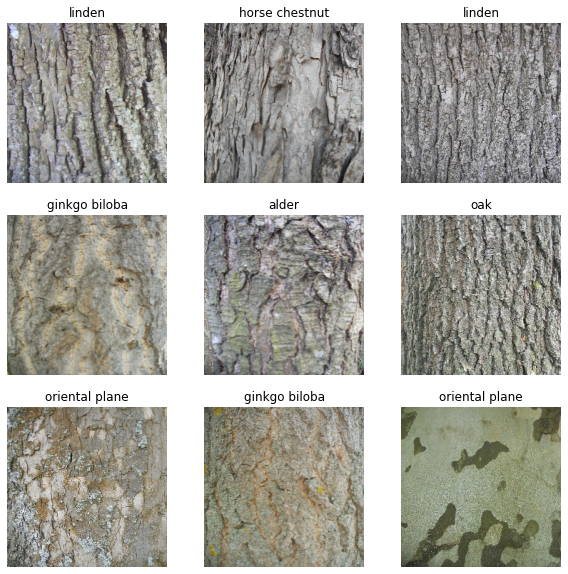

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
##Check also if the shape of the train set has the format (batch_size, image_height,image_width, rgb_channels )

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


## Self build model - For comparison (not for the task)

In [7]:
#AutoTune the dataset for perfomance reasons

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Normalize the pixels to `[0,1]`.

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.028409982 0.93497384


In [13]:
num_classes = 12

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
epochs=10

In [16]:
history=model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
15/15 [==============================] - 8s 475ms/step - loss: 2.6043 - accuracy: 0.1155 - val_loss: 2.4891 - val_accuracy: 0.0828
Epoch 2/10
15/15 [==============================] - 6s 386ms/step - loss: 2.4834 - accuracy: 0.1133 - val_loss: 2.4754 - val_accuracy: 0.0701
Epoch 3/10
15/15 [==============================] - 6s 390ms/step - loss: 2.4449 - accuracy: 0.1160 - val_loss: 2.4007 - val_accuracy: 0.1975
Epoch 4/10
15/15 [==============================] - 6s 392ms/step - loss: 2.3822 - accuracy: 0.1898 - val_loss: 2.2578 - val_accuracy: 0.2229
Epoch 5/10
15/15 [==============================] - 6s 392ms/step - loss: 2.1638 - accuracy: 0.2503 - val_loss: 2.3452 - val_accuracy: 0.1783
Epoch 6/10
15/15 [==============================] - 6s 395ms/step - loss: 2.0061 - accuracy: 0.3564 - val_loss: 2.2354 - val_accuracy: 0.2357
Epoch 7/10
15/15 [==============================] - 6s 396ms/step - loss: 1.6352 - accuracy: 0.4581 - val_loss: 2.1695 - val_accuracy: 0.3121
Epoch 

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 32)       

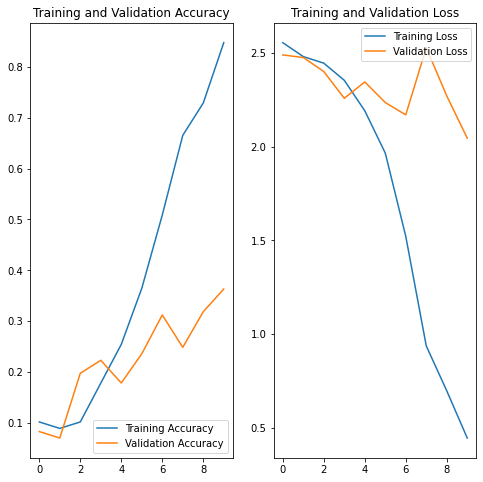

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Add data augmentation to the model to add extra pictures 

In [19]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

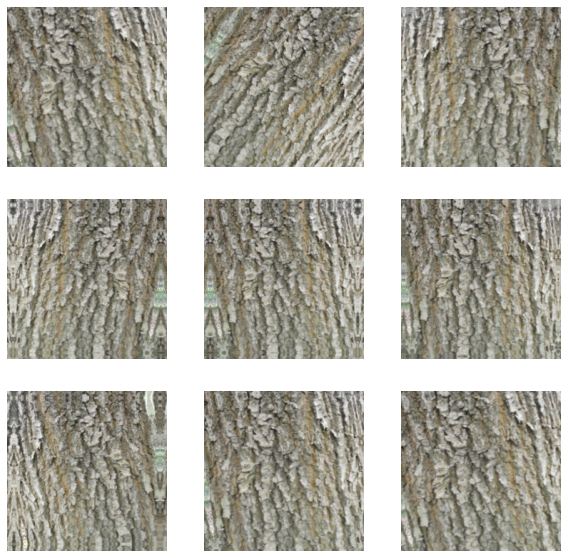

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [27]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 64)       

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/15
15/15 [==============================] - 8s 427ms/step - loss: 2.6935 - accuracy: 0.0979 - val_loss: 2.4781 - val_accuracy: 0.0701
Epoch 2/15
15/15 [==============================] - 5s 354ms/step - loss: 2.4750 - accuracy: 0.1001 - val_loss: 2.4490 - val_accuracy: 0.1210
Epoch 3/15
15/15 [==============================] - 5s 338ms/step - loss: 2.4441 - accuracy: 0.1146 - val_loss: 2.3729 - val_accuracy: 0.1401
Epoch 4/15
15/15 [==============================] - 5s 348ms/step - loss: 2.3745 - accuracy: 0.1387 - val_loss: 2.3040 - val_accuracy: 0.0701
Epoch 5/15
15/15 [==============================] - 5s 351ms/step - loss: 2.3098 - accuracy: 0.1185 - val_loss: 2.3965 - val_accuracy: 0.1529
Epoch 6/15
15/15 [==============================] - 5s 347ms/step - loss: 2.2033 - accuracy: 0.1596 - val_loss: 2.0086 - val_accuracy: 0.2611
Epoch 7/15
15/15 [==============================] - 5s 355ms/step - loss: 2.0737 - accuracy: 0.2216 - val_loss: 1.8925 - val_accuracy: 0.3121
Epoch 

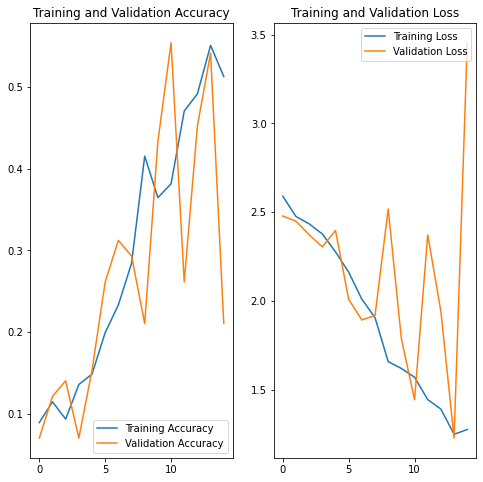

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
loss, accuracy = model.evaluate(test_ds)


10/10 [==============================] - 1s 101ms/step - loss: 3.4548 - accuracy: 0.2102


In [33]:
#Get test data 
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)


Predictions:
 [11, 11, 11, 11, 11, 11, 11, 2, 11, 11, 11, 11, 11, 11, 11, 9]
Labels:
 [ 8  3  4 11  8  1  0  2  9  6  4  8 11 10  8  5]


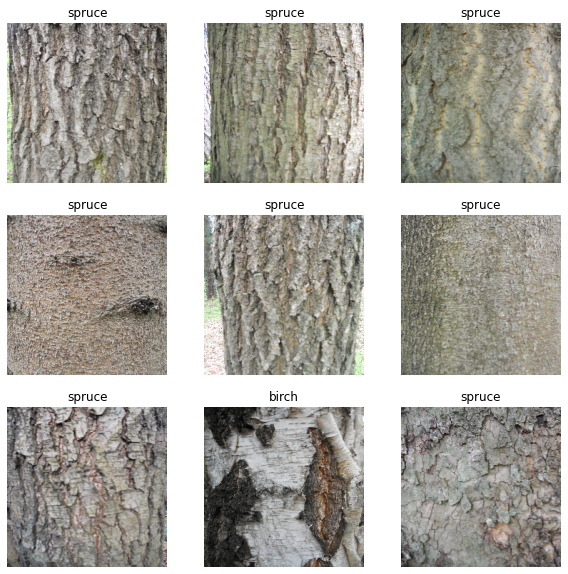

In [34]:
pred=[]
for i,e in enumerate(predictions.numpy()):
    pred.append(tf.argmax(e).numpy())

print('Predictions:\n', pred)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[pred[i]])
    plt.axis("off")

### => The model works but the accuracy is not so good 

## Usage of pretrained MobileNet model + extra layers to learn 

In [5]:
num_classes=12

### Split the test dataset into validation and testing set (20%)

In [6]:
val_batches = tf.data.experimental.cardinality(test_ds)
test_dataset = test_ds.take(val_batches // 4)
validation_dataset = test_ds.skip(val_batches // 4)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


### Also Usage of AutoTune for dataset performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Add Augmentation layer

In [9]:
data_augmentation_early = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

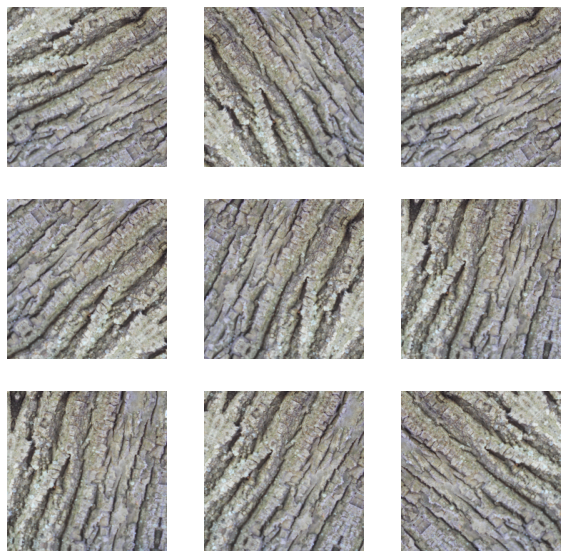

In [10]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [11]:
#Resaling layer of the rgb channels which are from [0;255] to [0;1] 

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [42]:
img_shape = (image_size,image_size) + (3,)
base_model = MobileNet(input_shape=img_shape,
                            include_top=False,
                            weights='imagenet')
base_model_early = tf.keras.Model(inputs=base_model.input,outputs=base_model.get_layer('conv_pw_6_relu').output)

In [43]:
#The base model converts the pictures from a shape of (224,224,3) to a blocks of the shape (7,7,1024 ) or (56,56,128)

image_batch, label_batch = next(iter(train_ds))
feature_batch_early = base_model_early(image_batch)
feature_batch = base_model(image_batch)

print(feature_batch_early.shape)
print(feature_batch.shape)

(16, 14, 14, 512)
(16, 7, 7, 1024)


In [44]:
#Set it to false beacue we don#t want to make the pretrained parameters of the base model to learn 

base_model.trainable = False
base_model_early.trainable = False

In [45]:
base_model.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [46]:
base_model_early.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [47]:
#Usage of AveragePooling after the base model to make it accessible for the Dense layers afterwards

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_early = global_average_layer(feature_batch_early)
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average_early.shape)
print(feature_batch_average.shape)

(16, 512)
(16, 1024)


In [48]:
prediction_layer_early = tf.keras.layers.Dense(num_classes)
prediction_batch_early = prediction_layer_early(feature_batch_average_early)

prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print("Early Layer Model: ",prediction_batch_early.shape)
print("Last Layer Model: ",prediction_batch.shape)

Early Layer Model:  (16, 12)
Last Layer Model:  (16, 12)


In [49]:
inputs_early = tf.keras.Input(shape=(image_size, image_size, 3))
inputs = tf.keras.Input(shape=(image_size, image_size, 3))

x_early = data_augmentation_early(inputs_early)
x = data_augmentation(inputs)

x_early = preprocess_input(x_early)
x = preprocess_input(x)

x_early=base_model_early(x_early, training=False)
x = base_model(x, training=False)

x_early = global_average_layer(x_early)
x = global_average_layer(x)
print(x_early.shape)
print(x.shape)
#x = layers.MaxPooling2D()(x),

x_early = tf.keras.layers.Dropout(0.2)(x_early)
x = tf.keras.layers.Dropout(0.2)(x)

#x=tf.keras.layers.Flatten()(x)
x_early = tf.keras.layers.Dense(512, activation='relu')(x_early)
x = tf.keras.layers.Dense(1024, activation='relu')(x)

x_early = tf.keras.layers.Dropout(0.5)(x_early)
x = tf.keras.layers.Dropout(0.5)(x)
print(x_early.shape)
print(x.shape)
outputs_early = prediction_layer_early(x_early)
outputs = prediction_layer(x)

model_early = tf.keras.Model(inputs_early, outputs_early)
model = tf.keras.Model(inputs, outputs)

(None, 512)
(None, 1024)
(None, 512)
(None, 1024)


In [50]:
base_learning_rate = 0.0001
model_early.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
model_early.summary()


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
model_6 (Functional)         (None, 14, 14, 512)       273600    
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0   

In [52]:
model.summary() 

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0   

In [53]:
len(model.trainable_variables)


4

In [54]:
initial_epochs = 10


In [55]:
history_early = model_early.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
15/15 [==============================] - 44s 2s/step - loss: 4.2478 - accuracy: 0.0747 - val_loss: 2.5453 - val_accuracy: 0.0800
Epoch 2/10
15/15 [==============================] - 38s 2s/step - loss: 3.4383 - accuracy: 0.1183 - val_loss: 2.5324 - val_accuracy: 0.1040
Epoch 3/10
15/15 [==============================] - 39s 2s/step - loss: 3.1599 - accuracy: 0.1620 - val_loss: 2.2843 - val_accuracy: 0.1280
Epoch 4/10
15/15 [==============================] - 40s 2s/step - loss: 2.9487 - accuracy: 0.1364 - val_loss: 2.1828 - val_accuracy: 0.2880
Epoch 5/10
15/15 [==============================] - 39s 2s/step - loss: 2.7990 - accuracy: 0.2101 - val_loss: 2.1397 - val_accuracy: 0.3040
Epoch 6/10
15/15 [==============================] - 39s 2s/step - loss: 2.7417 - accuracy: 0.1257 - val_loss: 2.1634 - val_accuracy: 0.2160
Epoch 7/10
15/15 [==============================] - 41s 2s/step - loss: 2.6025 - accuracy: 0.1452 - val_loss: 2.0506 - val_accuracy: 0.2800
Epoch 8/10
15/15 [==

In [57]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
15/15 [==============================] - 8s 408ms/step - loss: 3.0649 - accuracy: 0.1251 - val_loss: 2.1532 - val_accuracy: 0.2800
Epoch 2/10
15/15 [==============================] - 6s 378ms/step - loss: 2.2663 - accuracy: 0.2220 - val_loss: 1.8237 - val_accuracy: 0.4560
Epoch 3/10
15/15 [==============================] - 6s 377ms/step - loss: 1.9941 - accuracy: 0.3183 - val_loss: 1.5330 - val_accuracy: 0.6800
Epoch 4/10
15/15 [==============================] - 6s 388ms/step - loss: 1.7199 - accuracy: 0.4738 - val_loss: 1.3277 - val_accuracy: 0.7440
Epoch 5/10
15/15 [==============================] - 6s 417ms/step - loss: 1.5851 - accuracy: 0.4964 - val_loss: 1.1570 - val_accuracy: 0.8000
Epoch 6/10
15/15 [==============================] - 6s 400ms/step - loss: 1.2655 - accuracy: 0.6283 - val_loss: 1.0054 - val_accuracy: 0.8480
Epoch 7/10
15/15 [==============================] - 6s 407ms/step - loss: 1.2354 - accuracy: 0.6057 - val_loss: 0.8982 - val_accuracy: 0.8240
Epoch 

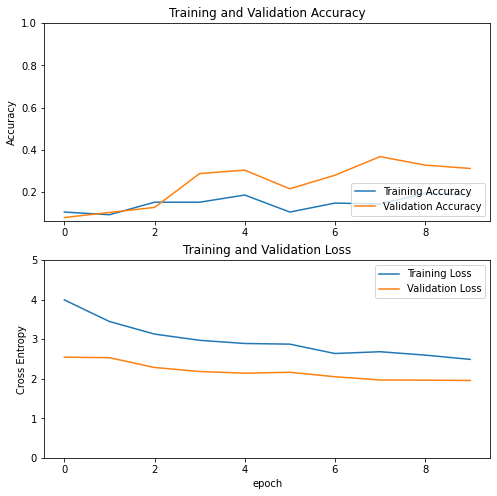

In [56]:
acc = history_early.history['accuracy']
val_acc = history_early.history['val_accuracy']

loss = history_early.history['loss']
val_loss = history_early.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

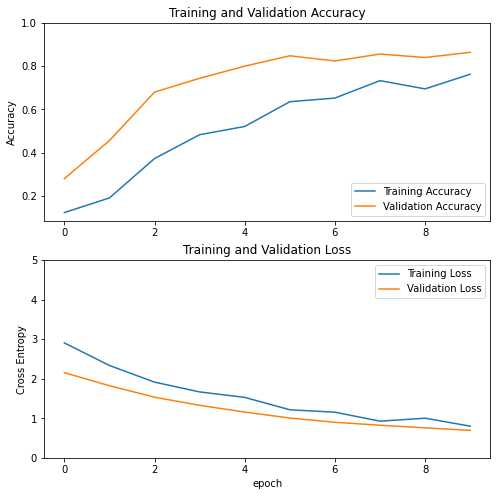

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Let's Finetune the basemodel, but just the last layers 

In [60]:
base_model.trainable = True

In [61]:
# Hoe many layers are in the model
print("Number layers: ", len(base_model.layers))

# Fine-tune from this layer
fine_tune_at = 40

print('Fine Tune layers onwards of layer: ',fine_tune_at)
# Set the layers to trainable from this layer onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number layers:  86
Fine Tune layers onwards of layer:  40


In [62]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0   

In [64]:
len(model.trainable_variables)

#because of the fine-tuning of the base model the learnable variables of the model increased

49

In [65]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
15/15 [==============================] - 15s 735ms/step - loss: 0.6843 - accuracy: 0.7733 - val_loss: 0.3875 - val_accuracy: 0.8720
Epoch 11/20
15/15 [==============================] - 10s 688ms/step - loss: 0.5417 - accuracy: 0.8480 - val_loss: 0.4325 - val_accuracy: 0.8640
Epoch 12/20
15/15 [==============================] - 10s 685ms/step - loss: 0.5011 - accuracy: 0.8454 - val_loss: 0.3650 - val_accuracy: 0.8880
Epoch 13/20
15/15 [==============================] - 10s 690ms/step - loss: 0.4471 - accuracy: 0.8716 - val_loss: 0.3380 - val_accuracy: 0.9120
Epoch 14/20
15/15 [==============================] - 10s 677ms/step - loss: 0.3683 - accuracy: 0.8593 - val_loss: 0.3205 - val_accuracy: 0.8960
Epoch 15/20
15/15 [==============================] - 10s 691ms/step - loss: 0.3272 - accuracy: 0.8999 - val_loss: 0.2799 - val_accuracy: 0.8960
Epoch 16/20
15/15 [==============================] - 10s 684ms/step - loss: 0.3238 - accuracy: 0.9042 - val_loss: 0.2716 - val_accuracy:

In [66]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

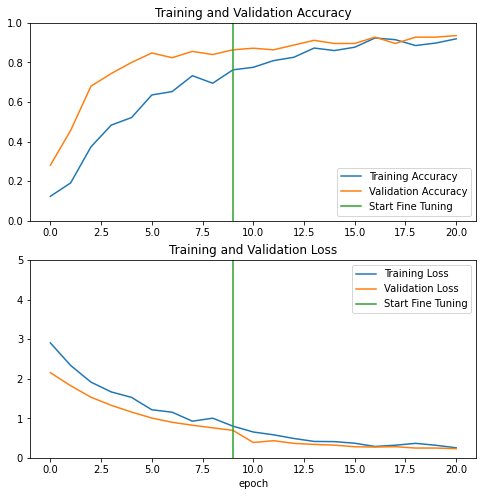

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [68]:
loss, accuracy = model_early.evaluate(test_dataset)
print('Accuracy :', accuracy)

2/2 [==============================] - 0s 148ms/step - loss: 2.3853 - accuracy: 0.1875
Accuracy : 0.1875


In [69]:
loss, accuracy = model.evaluate(test_dataset)
print('Accuracy :', accuracy)

2/2 [==============================] - 1s 402ms/step - loss: 0.3582 - accuracy: 0.8750
Accuracy : 0.875


In [70]:
#Get test data 
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_early.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)


Predictions:
 [8, 8, 8, 10, 8, 8, 8, 11, 8, 8, 8, 8, 8, 8, 8, 9]
Labels:
 [ 8  3  4 11  8  1  0  2  9  6  4  8 11 10  8  5]


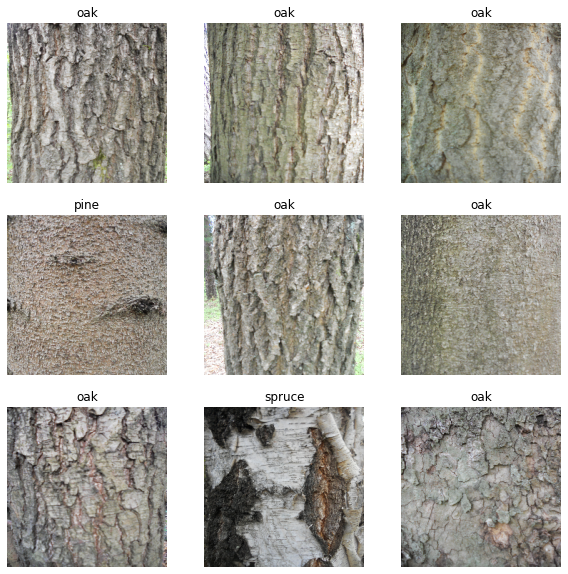

In [71]:
pred=[]
for i,e in enumerate(predictions.numpy()):
    pred.append(tf.argmax(e).numpy())
    
print('Predictions:\n', pred)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[pred[i]])
    plt.axis("off")

In [72]:
#Get test data 
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)


Predictions:
 [8, 3, 4, 11, 8, 11, 0, 2, 9, 6, 4, 3, 11, 10, 8, 1]
Labels:
 [ 8  3  4 11  8  1  0  2  9  6  4  8 11 10  8  5]


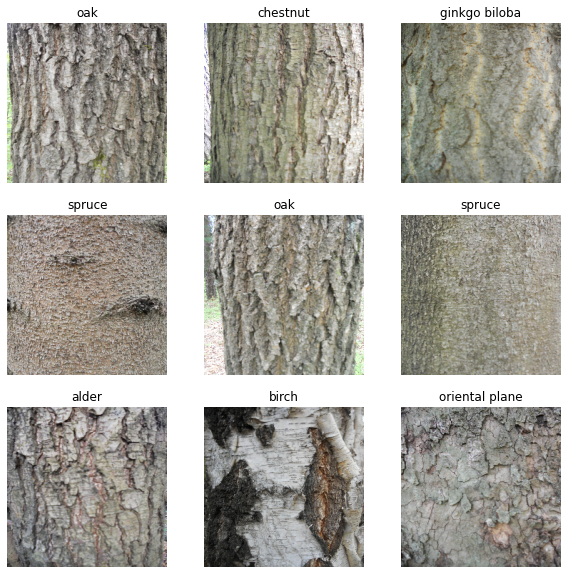

In [73]:
pred=[]
for i,e in enumerate(predictions.numpy()):
    pred.append(tf.argmax(e).numpy())

print('Predictions:\n', pred)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[pred[i]])
    plt.axis("off")

### => the fine-tuned model is much better than the model with just the early layers